In [13]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
from jax import jacfwd

In [14]:
def fig_config():
    fig, ax = plt.subplots(1, 1, figsize=(5., 5,))
    ax.set_aspect('equal')
    ax.set_xlim(-1.8, 3.2)
    ax.set_ylim(-0.7, 4.3)
    ax.set_facecolor('k')
    return fig, ax

In [15]:
vert_gt = np.array([
    [0.0, 0.0],
    [np.sqrt(2), 0],
    [np.sqrt(2) + 1, 1],
    [np.sqrt(2) + 1, np.sqrt(2) + 1],
    [np.sqrt(2), np.sqrt(2) + 2],
    [0.0, np.sqrt(2) + 2],
    [-1, np.sqrt(2) + 1],
    [-1, 1]
])

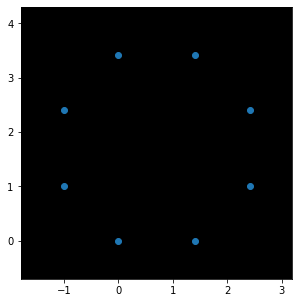

In [16]:
fig, ax = fig_config()
for vt in vert_gt:
    ax.plot(vt[0], vt[1], linestyle='', marker='o', color='C0')

In [17]:
edge_list = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 0],
    [0, 5],
    [1, 4],
    [2, 7],
    [3, 6]
], dtype=int)

In [18]:
vert_gt[edge_list[0]]

array([[0.        , 0.        ],
       [1.41421356, 0.        ]])

In [19]:
def plot_graph(vertices):
    fig, ax = fig_config()
    for ed in edge_list:
        ax.plot(vertices[ed][:,0], vertices[ed][:,1], linestyle='-', color='C1')
    for vt in vertices:
        ax.plot(vt[0], vt[1], linestyle='', marker='o', color='C0')
    plt.show()

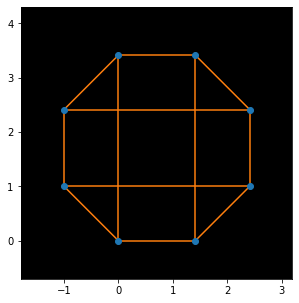

In [20]:
plot_graph(vert_gt)

In [21]:
def obs_func(v1, v2):
    return v2 - v1

In [22]:
obs_list = []
for ed in edge_list:
    v1 = vert_gt[ed[0]]
    v2 = vert_gt[ed[1]]
    obs = obs_func(v1, v2) 
    obs_list.append(obs)
obs_list = np.array(obs_list)
obs_list += mvn.rvs(mean=np.zeros(2), cov=np.diag(0.01*np.ones(2)), size=obs_list.shape[0]) # 0.1 is standard deviation
print(obs_list)

[[ 1.49786866e+00 -2.96748366e-03]
 [ 9.88839293e-01  9.12345975e-01]
 [-6.15764883e-02  1.48241502e+00]
 [-8.82877774e-01  9.85071562e-01]
 [-1.43250058e+00  4.71603059e-02]
 [-1.18063337e+00 -8.38079433e-01]
 [-1.31217435e-01 -1.68529822e+00]
 [ 7.92305800e-01 -8.22422282e-01]
 [-1.02716630e-01  3.33028223e+00]
 [-6.79060676e-02  3.69051660e+00]
 [-3.29738920e+00 -2.15189019e-02]
 [-3.30080870e+00  5.02501373e-02]]


In [23]:
def residuals(vertices):
    r = np.zeros_like(obs_list.ravel())
    v0 = vertices[0:2]
    r[0] = v0[0] - 0.
    r[1] = v0[1] - 0.
    for i in range(obs_list.shape[0]):
        obs = obs_list[i]
        ed = edge_list[i]
        vi = vertices[ed[0]*2: ed[0]*2+2]
        vj = vertices[ed[1]*2: ed[1]*2+2]
        obs_ij = obs_func(vi, vj)
        #print(obs, obs_ij)
        r[2*i+0] = obs_ij[0] - obs[0]
        r[2*i+1] = obs_ij[1] - obs[1]
    return r

objective = lambda vertices: np.linalg.norm(residuals(vertices)) ** 2

In [24]:
def real_objective(vertices):
    ret = vertices[0]**2 + vertices[1]**2 
    for i in range(obs_list.shape[0]):
        ed = edge_list[i]
        ret += (vertices[ed[1]*2] - vertices[ed[0]*2] - obs_list[i][0]) ** 2 
        ret += (vertices[ed[1]*2+1] - vertices[ed[0]*2+1] - obs_list[i][1]) ** 2
    return ret #/ 0.01

real_objective_grad = jacfwd(real_objective)

In [25]:
print(real_objective(vert_gt.ravel()))
print(real_objective_grad(vert_gt.ravel()))

0.39202568402831095
[ 0.37726533 -0.5289533  -0.32544407  0.38323295  0.1328175   0.2686729
  0.58420765 -0.06575925 -0.1350067  -0.4284286  -0.11925946  0.3973834
 -0.127978   -0.9665105  -0.38660225  0.94036233]


In [26]:
residuals(vert_gt.ravel())

array([-0.0836551 ,  0.00296748,  0.01116071,  0.08765403,  0.06157649,
       -0.06820145, -0.11712223,  0.01492844,  0.01828702, -0.04716031,
        0.18063337, -0.16192057,  0.13121744,  0.27108465,  0.2076942 ,
       -0.17757772,  0.10271663,  0.08393134,  0.06790607, -0.27630304,
       -0.11682436,  0.0215189 , -0.11340487, -0.05025014])

In [27]:
vert_k = vert_gt + mvn.rvs(mean=np.zeros(2), cov=np.diag(0.04*np.ones(2)), size=vert_gt.shape[0])

In [28]:
print('initial objective: ', objective(vert_k.ravel()))
print('ground-truth objective: ', objective(vert_gt.ravel()), real_objective(vert_gt.ravel()))

initial objective:  5.697623540474424
ground-truth objective:  0.3920256840283109 0.39202568402831095


In [29]:
def obsv_jac(vertices):
    ret = np.zeros((obs_list.ravel().shape[0], vertices.shape[0]))
    for i in range(obs_list.shape[0]):
        ed = edge_list[i]
        vid_i = ed[0]
        vid_j = ed[1]
        ret[2*i, 2*vid_i] = -1
        ret[2*i, 2*vid_j] = 1
        ret[2*i+1, 2*vid_i+1] = -1
        ret[2*i+1, 2*vid_j+1] = 1
    return ret

In [30]:
def armijo(obj, dobj, xk, pk):
    rho = 0.5
    alpha = 1.
    c =1e-04
    for i in range(20):
        gap = obj(xk + alpha * pk) - obj(xk) - c * alpha * (dobj(xk) @ pk)
        print(i, gap)
        if gap < 0.:
            return alpha
        else:
            alpha *= rho
    return alpha

In [31]:
# def grad_objective(vertices):
#     r = np.zeros_like(obs_list.ravel())
#     v0 = vertices[0]
#     r = jax.ops.index_update(r, 0, v0[0] - obs_list[0][0])
#     r = jax.ops.index_update(r, 1, v0[1] - obs_list[0][1])
#     for i in range(obs_list.shape[0]):
#         obs = obs_list[i]
#         ed = edge_list[i]
#         vi = vertices[ed[0]]
#         vj = vertices[ed[1]]
#         r = jax.ops.index_update(r, 2*i+0, obs_func(vi, vj)[0] - obs[0])
#         r = jax.ops.index_update(r, 2*i+1, obs_func(vi, vj)[1] - obs[1])
#     return np.dot(obsv_jac(vertices).T, r)

In [32]:
def grad_objective(vertices):
    r = residuals(vertices)
    J = obsv_jac(vertices)
    return 2 * J.T @ r / 0.04

In [33]:
grad_objective(vert_gt.ravel())

array([  9.43163351, -13.22382687,  -8.13609373,   9.58082496,
         3.32042882,   6.71682882,  14.60517899,  -1.64398769,
        -3.37515866, -10.71071484,  -2.98148606,   9.93457984,
        -3.19944673, -24.16276785,  -9.66505614,  23.50906363])

In [34]:
def gradient(vertices):
    ret = np.zeros_like(vertices)
    for i in range(obs_list.shape[0]):
        obs = obs_list[i]
        ed = edge_list[i]
        vi = vertices[ed[0]*2: ed[0]*2+2]
        vj = vertices[ed[1]*2: ed[1]*2+2]
        obs_ij = obs_func(vi, vj)
        
        grad_i = np.zeros_like(vertices)
        grad_i[ed[0]*2] = -1.
        grad_i[ed[1]*2] = 1.
        ret += 2 * (obs_ij[0] - obs[0]) * grad_i
        
        grad_j = np.zeros_like(vertices)
        grad_j[ed[0]*2 + 1] = -1.
        grad_j[ed[1]*2 + 1] = 1.
        ret += 2 * (obs_ij[1] - obs[1]) * grad_j
    
    return ret



obj:  2.831355744688663
pk:  4.2042875
0 218.6776
1 41.879192
2 4.0746894
3 -2.178881
alpha:  0.125


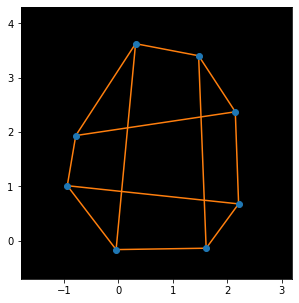



obj:  0.6518352
pk:  1.6155002
0 50.749943
1 10.081111
2 1.217091
3 -0.3473204
alpha:  0.125


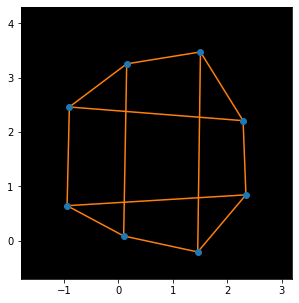



obj:  0.30438447
pk:  0.7329186
0 14.897155
1 2.9701962
2 0.3655025
3 -0.09714741
alpha:  0.125


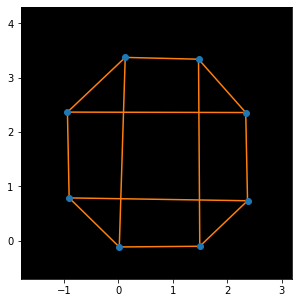



obj:  0.20719935
pk:  0.4556272
0 4.3859468
1 0.8762757
2 0.10896318
3 -0.027812019
alpha:  0.125


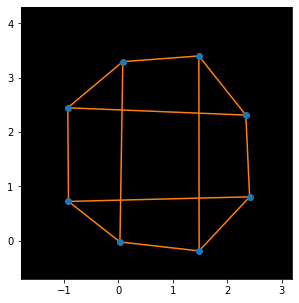



obj:  0.17937632
pk:  0.23488297
0 1.2916917
1 0.25811788
2 0.032127187
3 -0.008169465
alpha:  0.125


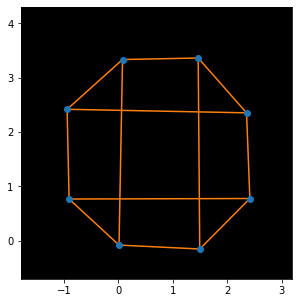



obj:  0.17120361
pk:  0.12273349
0 0.3797869
1 0.075589046
2 0.009218379
3 -0.002534867
alpha:  0.125


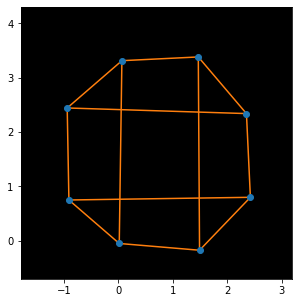



obj:  0.16866778
pk:  0.07896353
0 0.11088989
1 0.021704089
2 0.0024167805
3 -0.00090034015
alpha:  0.125


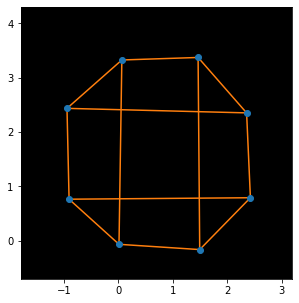



obj:  0.16776714
pk:  0.044243902
0 0.031598985
1 0.005815118
2 0.00041140604
3 -0.00041836506
alpha:  0.125


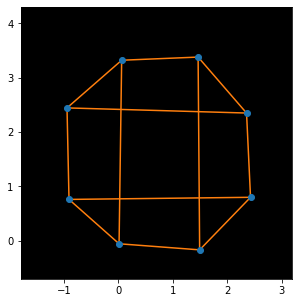



obj:  0.16734867
pk:  0.031177327
0 0.00824853
1 0.001149241
2 -0.00016909649
alpha:  0.25


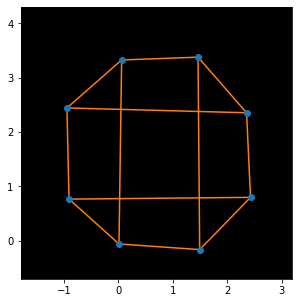



obj:  0.16717948
pk:  0.044873446
0 0.041199174
1 0.007848262
2 0.00073631783
3 -0.00042883714
alpha:  0.125


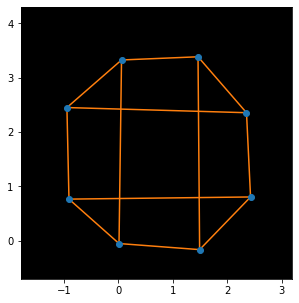

In [35]:
vert_k = vert_gt + mvn.rvs(mean=np.zeros(2), cov=np.diag(0.05*np.ones(2)), size=vert_gt.shape[0])
vert_k = vert_k.ravel()

for i in range(10):
    print('\n')
    
    objk = real_objective(vert_k)
    print('obj: ', objk)
    
#     Jk = obsv_jac(vert_k.ravel()) / 0.2
#     bk = residuals(vert_k.ravel()) / 0.2
#     pk = np.linalg.inv(Jk.T @ Jk) @ Jk.T @ bk
    
#     pk = grad_objective(vert_k.ravel())
#     pk = gradient(vert_k.ravel())
    pk = real_objective_grad(vert_k)
    
    print('pk: ', np.linalg.norm(pk, np.inf))
    alpha = armijo(real_objective, real_objective_grad, vert_k.ravel(), -pk)
#     alpha = 0.001
    print('alpha: ', alpha)
    
    plot_graph(vert_k.reshape(-1,2))
    vert_k -= alpha * pk